# Generate Legacy + Halpha Figures

* for ALMA targets

In [1]:
# register CS halpa with legacy r image

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp


In [2]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from PIL import Image

from astropy.io import fits
from astropy.wcs import WCS

from astropy.visualization import simple_norm
from astropy import units as u
from astropy.nddata.utils import Cutout2D

from astropy.coordinates import SkyCoord


from scipy.stats import scoreatpercentile


from astropy.cosmology import FlatLambdaCDM

# In this case we just need to define the matter density 
# and hubble parameter at z=0.

# Note the default units for the hubble parameter H0 are km/s/Mpc. 
# You can also pass an astropy `Quantity` with the units specified. 

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)



In [3]:
homedir = os.getenv("HOME")
os.chdir('/home/rfinn/research/Virgo/alma/2023/')

In [4]:
cutoutpath = os.path.join(homedir,'research/Virgo/all-cutouts-20210309','')
cutoutpath = os.path.join(homedir,'research/virgo-cutouts/all-cutouts-20210309','')
print(cutoutpath)

/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/


In [26]:
%run ~/github/Virgo/programs/readtablesv2.py

/home/rfinn/github/Virgo/programs/readtablesv2.py:142: RuntimeWarning: divide by zero encountered in log10
  g = 22.5 - 2.5*np.log10(dr9['FLUX_G'])
/home/rfinn/github/Virgo/programs/readtablesv2.py:142: RuntimeWarning: invalid value encountered in log10
  g = 22.5 - 2.5*np.log10(dr9['FLUX_G'])
/home/rfinn/github/Virgo/programs/readtablesv2.py:143: RuntimeWarning: divide by zero encountered in log10
  r = 22.5 - 2.5*np.log10(dr9['FLUX_R'])
/home/rfinn/github/Virgo/programs/readtablesv2.py:143: RuntimeWarning: invalid value encountered in log10
  r = 22.5 - 2.5*np.log10(dr9['FLUX_R'])
/home/rfinn/github/Virgo/programs/readtablesv2.py:144: RuntimeWarning: divide by zero encountered in log10
  z = 22.5 - 2.5*np.log10(dr9['FLUX_Z'])
/home/rfinn/github/Virgo/programs/readtablesv2.py:144: RuntimeWarning: invalid value encountered in log10
  z = 22.5 - 2.5*np.log10(dr9['FLUX_Z'])
/home/rfinn/github/Virgo/programs/readtablesv2.py:146: RuntimeWarning: invalid value encountered in log10
  const =

# Targets 2023

| object | halpha |HI | RA | DEC |
|-----|-----|----|---|----|
|NGC5248     | Y| N |204.38341666666668 |8.885166666666667|
|NGC5348     |Y|Y|208.54695833333332 |5.227444444444445|
|NGC5356     |Y|Y|208.74358333333333 |5.333722222222222|
|NGC5470     |N|N|211.63295833333333 |6.029694444444444|
|NGC5560     |Y|Y|215.01870833333334 |3.992472222222222|
|NGC5566     |Y|Y|215.08287500000003 |3.9337500000000003|
|NGC5577     |Y|Y|215.304625 |3.435777777777778|
|UGC9661     |N|N|225.514625 |1.841277777777778|


In [28]:
# checking to find VFID of each galaxy
names = ['NGC5248','NGC5348','NGC5356','NGC5470','NGC5560',\
         'NGC5566','NGC5577','NGC5806','CGCG 021-013', 'UGC9661']

for n in names:
    print(n)
    if np.sum(v.main['objname'] == n) > 0:
        print("v1 VFID: ",v.main['VFID_V1'][v.main['objname'] == n])
        print("v2 VFID: ", v.main['VFID'][v.main['objname'] == n])
        
    else:
        if n == 'UGC9661':
            nn = 'UGC09661'
            if np.sum(v.main['objname'] == nn) > 0:
                #print(np.arange(len(v.main))[v.main['objname'] == nn])
                print(v.main['VFID'][v.main['objname'] == nn])
            else:
                print("still no match!!!")
        else:
            if np.sum(v.main['NEDname'] == n) > 0:
                #print(np.arange(len(v.main))[v.main['objname'] == nn])
                print(v.main['VFID'][v.main['NEDname'] == n])
            else:
                print("still no match!!!")
            
    print()
    #print()

NGC5248
v1 VFID:  VFID_V1 
--------
VFID5308
v2 VFID:    VFID  
--------
VFID5292

NGC5348
v1 VFID:  VFID_V1 
--------
VFID5872
v2 VFID:    VFID  
--------
VFID5855

NGC5356
v1 VFID:  VFID_V1 
--------
VFID5859
v2 VFID:    VFID  
--------
VFID5842

NGC5470
v1 VFID:  VFID_V1 
--------
VFID5726
v2 VFID:    VFID  
--------
VFID5709

NGC5560
v1 VFID:  VFID_V1 
--------
VFID6035
v2 VFID:    VFID  
--------
VFID6018

NGC5566
v1 VFID:  VFID_V1 
--------
VFID6050
v2 VFID:    VFID  
--------
VFID6033

NGC5577
v1 VFID:  VFID_V1 
--------
VFID6108
v2 VFID:    VFID  
--------
VFID6091

NGC5806
v1 VFID:  VFID_V1 
--------
VFID6369
v2 VFID:    VFID  
--------
VFID6352

CGCG 021-013
  VFID  
--------
VFID6403

UGC9661
  VFID  
--------
VFID6362



In [102]:
# directories to cutouts for each galaxy
hapath = {'NGC5248':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID5308-NGC5248/',\
          'NGC5348':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID5872-NGC5348/',\
          'NGC5356':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID5859-NGC5356/',\
          'NGC5470':'/media/rfinn/hdata/cutouts/VFID5709-NGC5470-2017-05-20-WFC-VFID5726/',\
          'NGC5560':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID6035-NGC5560/',\
          'NGC5566':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID6050-NGC5566/',\
          'NGC5577':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID6108-NGC5577/',\
          #'NGC5806':, # no halpha cutout yet
          'CGCG 021-013':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID6420-CGCG021-013/', \
          'UGC9661': '/media/rfinn/hdata/cutouts/VFID6362-UGC09661-2021-04-18-90prime-VFID6406/'
         }

In [165]:
!ls

 MeerKAT_ALMA_target_list      'VF ALMA 2023 Figures.png'
 MeerKAT_ALMA_target_list.zip   VF-ALMA-2023-Figures.png
 mosaic_ALMA_pointings	        VFID5308-NGC5248-rgb-ha.png
 mosaic_ALMA_pointings.zip      VFID5709-NGC5470-rgb-ha.png
 NGC3504-12m.txt	        VFID5859-NGC5356-rgb-ha.png
 NGC4314-12m.txt	        VFID5872-NGC5348-rgb-ha.png
 NGC5348-12m.txt	        VFID5872-rgb-ha.png
 NGC5348-rgb-ha.png	        VFID6035-NGC5560-rgb-ha.png
 NGC5560-12m.txt	        VFID6035-rgb-ha.png
 NGC5560-rgb-ha.png	        VFID6050-NGC5566-rgb-ha.png
 NGC5577-12m.txt	        VFID6108-NGC5577-rgb-ha.png
 NGC5577-rgb-ha.png	        VFID6108-rgb-ha.png
 README			        VFID6362-UGC9661-rgb-ha.png
 UGC9661_mosaic-12m.txt         VirgoIII_ALMA_proposal_Cycle10.pdf


208.5469185 5.227286
vr =    vr  
------
1450.3
who's zoomin' who?

using ra and dec of galaxy to get center for zooming

xcenter,ycenter,xmax,ymax =  755 755 1509 1331
new image dimensions =  378 1132 378 1132
dimensions for halpha image =  378 1132 378 1132 754 754
(755, 755) (754, 754)

for jpeg image, xcenter,ycenter =  250 219 249.5
for fits image, xcenter,ycenter =  250 279 249.5

dimensions for cropped jpeg image =  125 375 94 344 250 250

shape of uncropped jpg data =  499 499


shape of cropped jpg data =  250 250

plotting alma centers
NGC5348_mosaic-12m.txt
pixel scale = 9.200665954268e-05 deg/pix
beam diam in pixels = 153.2437381655401

using ra and dec of galaxy to get center for zooming



/home/rfinn/github/Virgo/programs/alma2023.py:279: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  #plt.ylabel('Dec (deg)',fontsize=20)
/home/rfinn/github/Virgo/programs/alma2023.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xbar,ybar,'r-',lw=2,color=color)


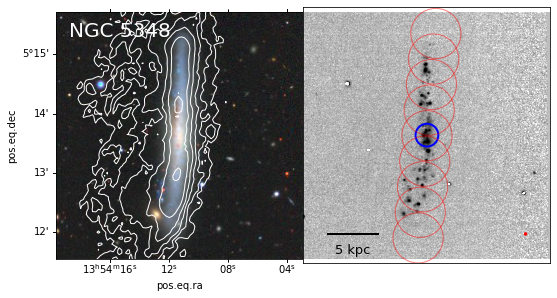

In [276]:
%run ~/github/Virgo/programs/alma2023.py
#############################
# VFID 5872 - NGC5348 - GAL 1
#############################
%matplotlib inline

cutouts =hapath['NGC5348']

haname = 'VFID5872-NGC5348-v19p120'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID5872-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID5872-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID_V1'] == 'VFID5872']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)


HIfile = 'MeerKAT_ALMA_target_list/J1355_fin_lw05_bpcorr_6_snr.fits'
#HImap = fits.open(HIfile)
HImap = fits.open('NGC5348_nhi.fits')
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=HImap[0],gra=gra,gdec=gdec,zoom=2,shitshow=False,alma=True,cmap='gray_r',pscale=.331,percentile1=10,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID5872-NGC5348'


#levels_HI = np.logspace(3,100,num=6)
#levels_HI = 2.**np.arange(10) + 1
#contarr = np.array([0,1,2,3,4,5])
#nhicont = 2.0**(contarr)*1e20
#HImap = fits.open('NGC5348_nhi.fits')
#HImap2 = fits.open(HIfile)
#fig.show_contour('NGC5348_nhi.fits', colors='white', linewidths=1.5, levels=nhicont) 
#w = WCS(HImap[0].header)
#plt.contour((HImap[0].data),transform=ax.get_transform(w),levels=nhicont, colors='white',linestyles='-',linewidths=1)
#########################################
# try mpati's way of doing contours
#HImap.close()
#HImap2.close()


# in_mom_hi = 'NGC5348_mom0.fits'
# in_mom_hi = 'MeerKAT_ALMA_target_list/J1355_fin_lw05_bpcorr_6_mom0.fits'
# outnhi = 'NGC5348_nhi.fits'

# ## read in the mom0 fits file and convert to HI column density
# from astropy.io import fits
# f=fits.open(in_mom_hi)
# flux=f[0].data   # (Jy/beam) * m/s
# fluxhead=f[0].header

# IntFluxmJy=(flux)/((fluxhead['BMAJ']*3600)*(fluxhead['BMIN']*3600))   # (mJy/beam)*km/s
# K = (1.823e18)*(606)    
# nhi=K*(IntFluxmJy)
# fluxhead['BUNIT'] = 'atoms/cm2'
# fits.writeto(outnhi,nhi,header=fluxhead, overwrite=True)


# import aplpy
# # HI column density contours
# contarr = np.array([0,1,2,3,4,5])
# nhicont = 2.0**(contarr)*1e20

# fig = aplpy.FITSFigure(legacy_r)
# fig.show_contour('NGC5348_nhi.fits', colors='white', linewidths=1.5, levels=nhicont)
# fig.show_colorscale(cmap='gray')

# fig.axis_labels.set_xtext('Right Ascension (J2000)')
# fig.axis_labels.set_ytext('Declination (J2000)')
# fig.axis_labels.set_font(size='xx-large', weight='medium', \
#                          stretch='normal', family='sans-serif', \
#                          style='normal', variant='normal')
# plt.show()
# fig.save('testngc5348.png')


#plt.savefig(vname+'-rgb-ha.png')
plt.savefig(vname+'-rgb-ha.png')

208.7435295 5.3337007
vr =    vr  
------
1369.8
who's zoomin' who?

using ra and dec of galaxy to get center for zooming

xcenter,ycenter,xmax,ymax =  755 755 1509 1509
new image dimensions =  378 1132 378 1132
dimensions for halpha image =  378 1132 378 1132 754 754
(755, 755) (754, 754)

for jpeg image, xcenter,ycenter =  250 248 249.5
for fits image, xcenter,ycenter =  250 250 249.5

dimensions for cropped jpeg image =  125 375 123 373 250 250

shape of uncropped jpg data =  499 499


shape of cropped jpg data =  250 250

plotting alma centers
NGC5356_mosaic-12m.txt
pixel scale = 9.200665954268e-05 deg/pix
beam diam in pixels = 153.21052800911508

using ra and dec of galaxy to get center for zooming



/home/rfinn/github/Virgo/programs/alma2023.py:279: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  #plt.ylabel('Dec (deg)',fontsize=20)
/home/rfinn/github/Virgo/programs/alma2023.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xbar,ybar,'r-',lw=2,color=color)


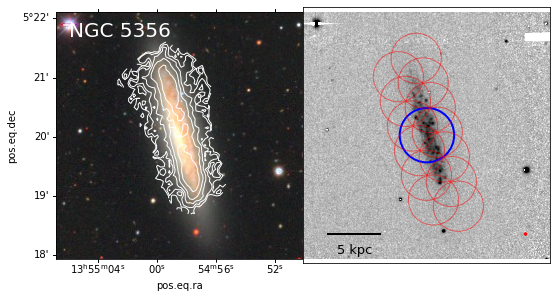

In [277]:
#############################
# VFID 5859 - NGC5356 - GAL2
#############################

cutouts =hapath['NGC5356']

haname = 'VFID5859-NGC5356-v19p120'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID5859-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID5859-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID_V1'] == 'VFID5859']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)


HIfile = 'MeerKAT_ALMA_target_list/J1355_fin_lw05_bpcorr_5_snr.fits'
HImap = fits.open(HIfile)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=HImap[0],alma=True,cmap='gray_r',zoom=2,pscale=.331,percentile1=7,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID5859-NGC5356'

# overlay HI contours on RBG image


#plt.savefig(vname+'-rgb-ha.png')
plt.savefig(vname+'-rgb-ha.png')

211.6329645 6.0293208
vr =    vr  
------
1020.3
who's zoomin' who?

using ra and dec of galaxy to get center for zooming

xcenter,ycenter,xmax,ymax =  725 725 1449 1449
new image dimensions =  363 1087 363 1087
dimensions for halpha image =  363 1087 363 1087 724 724
(725, 725) (724, 724)

for jpeg image, xcenter,ycenter =  240 238 239.5
for fits image, xcenter,ycenter =  240 240 239.5

dimensions for cropped jpeg image =  120 360 118 358 240 240

shape of uncropped jpg data =  479 479


shape of cropped jpg data =  240 240

plotting alma centers
NGC5470_mosaic-12m.txt
pixel scale = 9.194444444444e-05 deg/pix
beam diam in pixels = 153.1359516616388

using ra and dec of galaxy to get center for zooming



/home/rfinn/github/Virgo/programs/alma2023.py:279: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  #plt.ylabel('Dec (deg)',fontsize=20)
/home/rfinn/github/Virgo/programs/alma2023.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xbar,ybar,'r-',lw=2,color=color)


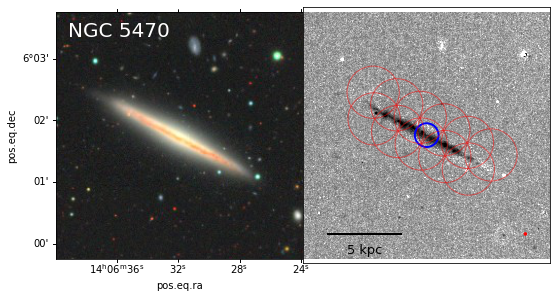

In [278]:
#############################
# VFID5726-NGC5470 - GAL3
# 
# SKIPPING - this looks like INT WFC data from 2017, which would be in the wrong filter :(
# no legacy cutouts
# hopefully we observed this one again at some point...
#############################


#UGH - this is a v2 VFID name


cutouts =hapath['NGC5470']

# this cutout was made using v2 catalogs...
haname = 'VFID5709-NGC5470-2017-05-20-WFC-VFID5726'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID5709-legacy-479-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID5709-legacy-479.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID5709']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)


#HIfile = 'MeerKAT_ALMA_target_list/J1355_fin_lw05_bpcorr_5_snr.fits'
#HImap = fits.open(HIfile)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=None,alma=True,cmap='gray_r',zoom=2,pscale=.331,percentile1=15,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID5709-NGC5470'

# overlay HI contours on RBG image


#plt.savefig(vname+'-rgb-ha.png')
plt.savefig(vname+'-rgb-ha.png')

215.018397 3.992753
vr =    vr  
------
1730.2
who's zoomin' who?

using ra and dec of galaxy to get center for zooming

xcenter,ycenter,xmax,ymax =  755 755 1508 1508
new image dimensions =  378 1132 378 1132
dimensions for halpha image =  378 1132 378 1132 754 754
(755, 755) (754, 754)

for jpeg image, xcenter,ycenter =  250 248 249.5
for fits image, xcenter,ycenter =  250 250 249.5

dimensions for cropped jpeg image =  125 375 123 373 250 250

shape of uncropped jpg data =  499 499


shape of cropped jpg data =  250 250

plotting alma centers
NGC5560_mosaic-12m.txt
pixel scale = 9.201090142597e-05 deg/pix
beam diam in pixels = 153.39365955722783

using ra and dec of galaxy to get center for zooming



/home/rfinn/github/Virgo/programs/alma2023.py:279: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  #plt.ylabel('Dec (deg)',fontsize=20)
/home/rfinn/github/Virgo/programs/alma2023.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xbar,ybar,'r-',lw=2,color=color)


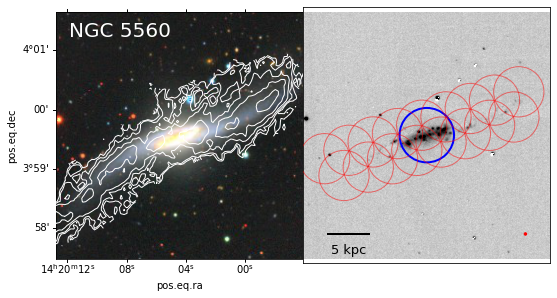

In [279]:
#############################
# VFID6035-NGC5560 - GAL 4
#############################

cutouts = os.path.join(cutoutpath,'VFID6035-NGC5560','')
haname = 'VFID6035-NGC5560-v19p131'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID6035-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID6035-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID_V1'] == 'VFID6035']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)

HIfile = 'MeerKAT_ALMA_target_list/J1420_fin_lw05_pbcorr_4_snr.fits'
HImap = fits.open(HIfile)
#HImap[0].data = np.fliplr(HImap[0].data)
                      
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=HImap[0],alma=True,zoom=2.,cmap='gray_r',pscale=.331,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID6035-NGC5560'
plt.savefig(vname+'-rgb-ha.png')
#plt.savefig(ned.replace(' ','')+'-rgb-ha.png')

legacy_r =  /home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID6050-NGC5566/legacy/VFID6050-legacy-499-r.fits
215.08269149999998 3.9335328
vr =    vr  
------
1529.0
who's zoomin' who?

using ra and dec of galaxy to get center for zooming

xcenter,ycenter,xmax,ymax =  755 754 1508 1508
new image dimensions =  252 1258 251 1257
dimensions for halpha image =  252 1258 251 1257 1006 1006
(755, 754) (1006, 1006)

for jpeg image, xcenter,ycenter =  250 248 249.5
for fits image, xcenter,ycenter =  250 250 249.5

dimensions for cropped jpeg image =  84 416 82 414 332 332

shape of uncropped jpg data =  499 499


shape of cropped jpg data =  332 332



/home/rfinn/github/Virgo/programs/alma2023.py:279: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  #plt.ylabel('Dec (deg)',fontsize=20)
/home/rfinn/github/Virgo/programs/alma2023.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xbar,ybar,'r-',lw=2,color=color)


plotting alma centers
NGC5566_mosaic-12m.txt
pixel scale = 9.201090142597e-05 deg/pix
beam diam in pixels = 153.26988195357012

using ra and dec of galaxy to get center for zooming



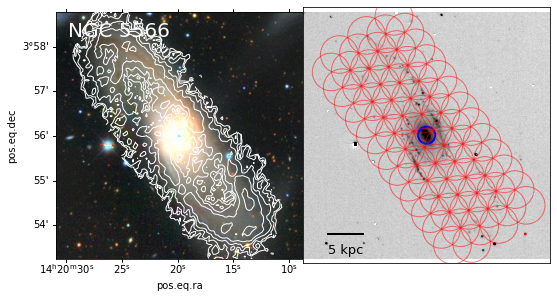

In [280]:
#############################
# VFID6050-NGC5566 - GAL 5
#############################

cutouts =hapath['NGC5566']

haname = 'VFID6050-NGC5566-v19p131'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID6050-legacy-499-r.fits')
print("legacy_r = ",legacy_r)
legacy_jpg = os.path.join(cutouts,'legacy','VFID6050-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID_V1'] == 'VFID6050']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)


HIfile = 'MeerKAT_ALMA_target_list/J1420_fin_lw05_pbcorr_1_snr.fits'
HImap = fits.open(HIfile)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=HImap[0],alma=True,cmap='gray_r',zoom=1.5,pscale=.331,percentile1=1,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID6050-NGC5566'

# overlay HI contours on RBG image


#plt.savefig(vname+'-rgb-ha.png')
plt.savefig(vname+'-rgb-ha.png')

215.30457149999998 3.4358432
vr =    vr  
------
1489.1
who's zoomin' who?

using ra and dec of galaxy to get center for zooming

xcenter,ycenter,xmax,ymax =  755 755 1509 1509
new image dimensions =  378 1132 378 1132
dimensions for halpha image =  378 1132 378 1132 754 754
(755, 755) (754, 754)

for jpeg image, xcenter,ycenter =  250 248 249.5
for fits image, xcenter,ycenter =  250 250 249.5

dimensions for cropped jpeg image =  125 375 123 373 250 250

shape of uncropped jpg data =  499 499


shape of cropped jpg data =  250 250

plotting alma centers
NGC5577_mosaic-12m.txt
pixel scale = 9.200673957821e-05 deg/pix
beam diam in pixels = 153.27077678322834

using ra and dec of galaxy to get center for zooming



/home/rfinn/github/Virgo/programs/alma2023.py:279: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  #plt.ylabel('Dec (deg)',fontsize=20)
/home/rfinn/github/Virgo/programs/alma2023.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xbar,ybar,'r-',lw=2,color=color)


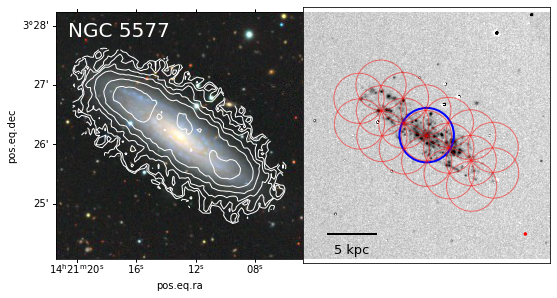

In [281]:
#############################
# VFID6108-NGC5577 - GAL 6
#############################

cutouts = os.path.join(cutoutpath,'VFID6108-NGC5577','')
haname = 'VFID6108-NGC5577-v19p134'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID6108-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID6108-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID_V1'] == 'VFID6108']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)

HIfile = 'MeerKAT_ALMA_target_list/J1420_fin_lw05_pbcorr_2_snr.fits'
HImap = fits.open(HIfile)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=HImap[0],alma=True,cmap='gray_r',zoom=2.,pscale=.331,percentile1=10,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID6108-NGC5577'

# overlay HI contours on RBG image


plt.savefig(vname+'-rgb-ha.png')
#plt.savefig(ned.replace(' ','')+'-rgb-ha.png')

225.514689 1.8410998
vr =    vr  
------
1242.5
who's zoomin' who?

using ra and dec of galaxy to get center for zooming

xcenter,ycenter,xmax,ymax =  331 332 662 662
new image dimensions =  165 497 166 498
dimensions for halpha image =  165 497 166 498 332 332
(331, 332) (332, 332)

for jpeg image, xcenter,ycenter =  150 148 149.5
for fits image, xcenter,ycenter =  150 150 149.5

dimensions for cropped jpeg image =  75 225 73 223 150 150

shape of uncropped jpg data =  299 299


shape of cropped jpg data =  150 150

plotting alma centers
UGC09661_mosaic-12m.txt
pixel scale = 0.0001258759584744 deg/pix
beam diam in pixels = 111.93559255293017

using ra and dec of galaxy to get center for zooming



/home/rfinn/github/Virgo/programs/alma2023.py:279: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  #plt.ylabel('Dec (deg)',fontsize=20)
/home/rfinn/github/Virgo/programs/alma2023.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xbar,ybar,'r-',lw=2,color=color)


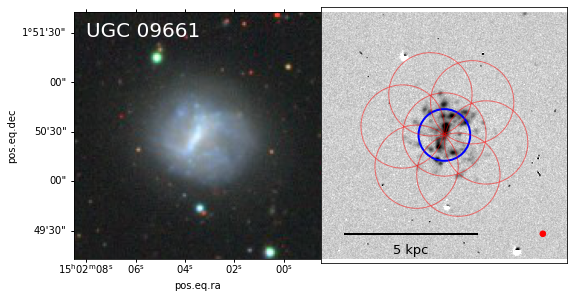

In [282]:
#############################
# VFID6379-UGC9661 - GAL 7
#
# no halpha cutout yet - working on this
#
# FOUND IT!!!
# 
# it is in VF-20210418-BOK-VFID6406
#############################



cutouts =hapath['UGC9661']

# this cutout was made using v2 catalogs...
haname = 'VFID6362-UGC09661-2021-04-18-90prime-VFID6406'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID6362-legacy-299-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID6362-legacy-299.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID6362']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)


#HIfile = 'MeerKAT_ALMA_target_list/J1355_fin_lw05_bpcorr_5_snr.fits'
#HImap = fits.open(HIfile)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=None,alma=True,cmap='gray_r',zoom=2,pscale=.331,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID6362-UGC9661'

# overlay HI contours on RBG image


#plt.savefig(vname+'-rgb-ha.png')
plt.savefig(vname+'-rgb-ha.png')

204.3834195 8.885176
vr =    vr  
------
1152.1
who's zoomin' who?
755 755
252 1258 252 1258
252 1258 252 1258
(755, 755) (1006, 1006)
ycenter =  248 249.5
84 416 82 414


plotting alma centers


/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:162: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


KeyError: 'NGC 5248'

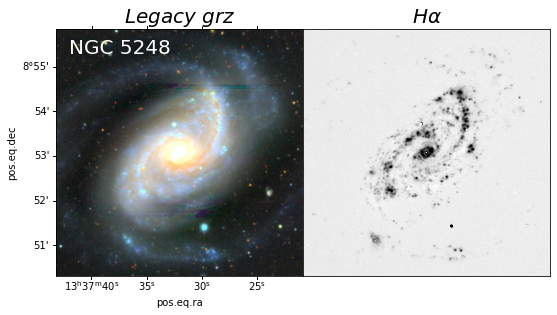

In [73]:
###################################
# VFID 5308 - NGC5248 - DROPPED!!! 
###################################

cutouts =hapath['NGC5248']

haname = 'VFID5308-NGC5248-v19p107'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID5308-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID5308-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID_V1'] == 'VFID5308']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)

# not observed yet!
#HIfile = 'MeerKAT_ALMA_target_list/J1420_fin_lw05_pbcorr_2_snr.fits'
#HImap = fits.open(HIfile)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=None,alma=True,cmap='gray_r',zoom=1.5,pscale=.331,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID5308-NGC5248'

# overlay HI contours on RBG image


#plt.savefig(vname+'-rgb-ha.png')
plt.savefig(vname+'-rgb-ha.png')